# LSTM модель классификация по 3 классам

In [1]:
#Подключаем библиотеки
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os
import random
from scipy import stats
import plotly.express as px
import talib
import matplotlib.pyplot as plt
import pywt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import optuna
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset,ConcatDataset
from optuna.trial import Trial
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
from datetime import date, datetime, timedelta
from plotly.subplots import make_subplots
from backtesting import Backtest, Strategy

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Oks\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Oks\anaconda3\envs\py311\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
device

device(type='cuda')

In [3]:
SEED = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def seed_everything(seed: int = 42) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

seed_everything(SEED)

In [4]:
# Загружаем данные
data_rus = pd.read_csv('Investing_data_rus.csv')
data_usa = pd.read_csv('Investing_data_usa.csv')
data = pd.concat([data_rus, data_usa], axis=0, ignore_index=True)
data['Date'] =  pd.to_datetime(data['Date'], format='ISO8601')
data[['rus', 'usa']] = data[['rus', 'usa']].fillna(0)
data.drop(['Adj Close'], axis=1, inplace=True)

In [5]:
data

,tic,Open,Close,High,Low,Volume,Date,rus,usa
0,BANEP,927.000000,935.000000,944.000000,915.000000,16034.0,2015-01-05,1.0,0.0
1,BANEP,928.000000,926.000000,938.000000,921.000000,9201.0,2015-01-06,1.0,0.0
2,BANEP,927.000000,956.000000,965.000000,925.000000,74265.0,2015-01-08,1.0,0.0
3,BANEP,956.000000,938.000000,967.000000,925.000000,47926.0,2015-01-09,1.0,0.0
4,BANEP,934.000000,935.000000,942.000000,922.000000,21278.0,2015-01-12,1.0,0.0
...,...,...,...,...,...,...,...,...,...
535250,XOM,112.349998,112.120003,112.529999,110.680000,28540200.0,2025-06-13,0.0,1.0
535251,XOM,111.820000,112.480003,113.160004,111.129997,22986100.0,2025-06-16,0.0,1.0
535252,XOM,113.949997,114.000000,114.930000,113.110001,19451700.0,2025-06-17,0.0,1.0
535253,XOM,114.610001,113.190002,115.239998,112.940002,17968900.0,2025-06-18,0.0,1.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535255 entries, 0 to 535254
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   tic     535255 non-null  object        
 1   Open    535255 non-null  float64       
 2   Close   535255 non-null  float64       
 3   High    535255 non-null  float64       
 4   Low     535255 non-null  float64       
 5   Volume  535255 non-null  float64       
 6   Date    535255 non-null  datetime64[ns]
 7   rus     535255 non-null  float64       
 8   usa     535255 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 36.8+ MB


In [7]:
data = data[data.groupby('tic')['tic'].transform('count') >= 1000]

#### Добавляем признаки

In [8]:
tickers = data['tic'].unique()
df = pd.DataFrame()
for i in tickers:
    data_temp = data.loc[data['tic'] == i]
    data_temp.loc[:,['sma_5']] = talib.SMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,['sma_10']] = talib.SMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,['sma_15']] = talib.SMA(data_temp["Close"], timeperiod=15)
    data_temp.loc[:,['sma_20']] = talib.SMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,['sma_50']] = talib.SMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,['sma_200']] = talib.SMA(data_temp["Close"], timeperiod=200)
    data_temp.loc[:,['sma_ratio_5_15']] = data_temp['sma_15'] / data_temp['sma_5']
    data_temp.loc[:,['sma_ratio_10_50']] = data_temp['sma_50'] / data_temp['sma_15']
    data_temp.loc[:,['sma_5_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=5)
    data_temp.loc[:,['sma_10_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=10)
    data_temp.loc[:,['sma_15_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=15)
    data_temp.loc[:,['sma_50_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=50)
    data_temp.loc[:,["sma_Volume_ratio_5_15"]] = data_temp['sma_5_Volume'] / data_temp['sma_15_Volume']
    data_temp.loc[:,["sma_Volume_ratio_10_50"]] = data_temp['sma_10_Volume'] / data_temp['sma_50_Volume']
    data_temp.loc[:,["ema_5"]] = talib.EMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,["ema_10"]] = talib.EMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,["ema_20"]] = talib.EMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,["ema_50"]] = talib.EMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,["ema_200"]] = talib.EMA(data_temp["Close"], timeperiod=200)
    
    # Calculate the Bollinger Bands
    data_temp.loc[:,["upper_band"]], data_temp.loc[:,["middle_band"]], data_temp.loc[:,["lower_band"]] = talib.BBANDS(data_temp["Close"], timeperiod=20)
    
    # Calculate the relative strength index (RSI)
    data_temp.loc[:,["RSI"]] = talib.RSI(data_temp["Close"], timeperiod=14)
    
    # Calculate the MACD
    data_temp.loc[:,["macd"]], data_temp.loc[:,["macd_signal"]], data_temp.loc[:,["macd_hist"]] = talib.MACD(data_temp["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data_temp.loc[:,['day_of_week']] = data_temp['Date'].dt.dayofweek   
    data_temp.loc[:,['lag_1day']] = data_temp['Close'].shift(1)    
    data_temp.loc[:,['ADX_5']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['ADX_15']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=15)
    
    data_temp.loc[:,['RSI_5']] = talib.RSI(data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['RSI_15']] = talib.RSI(data_temp['Close'], timeperiod=15)
    data_temp.loc[:,['RSI_ratio']] = data_temp['RSI_5']/data_temp['RSI_15']
    
    data_temp.loc[:,['ROC']] = talib.ROC(data_temp['Close'], timeperiod=15)

    data_temp.loc[:,['HAMMER']] = talib.CDLHAMMER(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['SHOOTING_STAR']] = talib.CDLSHOOTINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['ENGULFING']] = talib.CDLENGULFING(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MORNING_STAR']] = talib.CDLMORNINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['EVENING_STAR']] = talib.CDLEVENINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MARUBOZU']] = talib.CDLMARUBOZU(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['DOJI']] = talib.CDLDOJI(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    
    data_temp.loc[:,['diff']] = -data_temp['Close'].diff(periods=-1)/data_temp['Close']
    
    #Определим, что значение таргета как 0, 1, 2 (продажа/держать/покупка) с учетом комиссии в 0.5%
    data_temp.loc[:,['target']] = 1
    data_temp.loc[data_temp['diff'] > 0.005, 'target'] = 2
    data_temp.loc[data_temp['diff'] < -0.005, 'target'] = 0
    
    data_temp.dropna(inplace=True)
    df = pd.concat([df, data_temp], ignore_index=True)

In [9]:
#Определим признаки, с которыми будет работать модель
features = ['Close','rus','usa', 'sma_5', 'sma_10', 'sma_15', 'sma_50', 'sma_200', 'sma_ratio_5_15', 'sma_ratio_10_50', 
            'sma_5_Volume', 'sma_10_Volume', 'sma_15_Volume', 'sma_50_Volume', 'sma_Volume_ratio_5_15', 'sma_Volume_ratio_10_50',
            'ema_5', 'ema_10','ema_20','ema_50','ema_200','upper_band',
            'middle_band', 'lower_band', 'RSI', 'macd', 'macd_signal', 'macd_hist','day_of_week','lag_1day',
            'ADX_5', 'ADX_15', 'RSI_5', 'RSI_15', 'RSI_ratio', 'ROC','HAMMER','SHOOTING_STAR','ENGULFING','MORNING_STAR','EVENING_STAR','MARUBOZU','DOJI'
           ]
not_features = [col for col in df.columns if col not in features]

In [10]:
df.dropna(inplace=True)
df = df.sort_values(by = ['Date','tic'],ascending = True, ignore_index = True)

#### Подготовим данные, делим и нормализируем

In [11]:
def split_by_date(df, train_ratio=0.7, val_ratio=0.15):
    dates = df['Date'].unique()
    train_end = int(len(dates) * train_ratio)
    val_end = train_end + int(len(dates) * val_ratio)
    train_dates = dates[:train_end]
    val_dates = dates[train_end:val_end]
    test_dates = dates[val_end:]
    return train_dates, val_dates, test_dates

def prepare_data(
    df,
    features,
    target=None,
    model_type='lstm',  
    window=30,
    train_ratio=0.7,
    val_ratio=0.15,
    batch_size=32
):
    raw_data = df.copy()
    
    train_dates, val_dates, test_dates = split_by_date(df, train_ratio, val_ratio)
    scalers = {}
    
    def process_data(data, is_train=False):
        results = []
        raw_results = []
        
        for tic in data['tic'].unique():
            tic_data = data[data['tic'] == tic].sort_values('Date')
            
            if is_train:
                scaler = MinMaxScaler()
                scaled_features = scaler.fit_transform(tic_data[features])
                scalers[tic] = scaler
            else:
                if tic not in scalers:
                    print(f"Scaler для тикера {tic} не найден. Пропускаем.")
                    continue  
                scaled_features = scalers[tic].transform(tic_data[features])

            target_idx = features.index(target) if target in features else None
            
            X, y = [], []
            for i in range(len(scaled_features) - window):
                X.append(scaled_features[i:i+window])
                y.append(tic_data[target].iloc[i+window])

            if len(X) > 0:
                results.append((np.array(X), np.array(y)))
                raw_results.append(tic_data.iloc[window:].copy())
        
        if results:
            X = np.concatenate([r[0] for r in results])
            y = np.concatenate([r[1] for r in results])
            raw_df = pd.concat(raw_results)
            return X, y, raw_df
        else:
            return None, None, None
    
    X_train, y_train, train_raw = process_data(df[df['Date'].isin(train_dates)], is_train=True)
    X_val, y_val, val_raw = process_data(df[df['Date'].isin(val_dates)])
    X_test, y_test, test_raw = process_data(df[df['Date'].isin(test_dates)])

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    
    def create_dataloader(X, y, shuffle=False, current_model_type='lstm'):
        if X is None or y is None:
            return None
        
        X_tensor = torch.FloatTensor(X)
        
        if current_model_type == 'lstm':
            y_tensor = torch.LongTensor(y.astype(int))
        
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    train_loader = create_dataloader(X_train, y_train, shuffle=True, current_model_type=model_type)
    val_loader = create_dataloader(X_val, y_val, current_model_type=model_type)
    test_loader = create_dataloader(X_test, y_test, current_model_type=model_type)
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_raw': train_raw,
        'val_raw': val_raw,
        'test_raw': test_raw,
        'scalers': scalers
    }

#### Создаем LSTM модель

In [12]:
# Для LSTM (классификация) готовим данные
lstm_data = prepare_data(
    df=df,
    features=features,
    target='target', 
    model_type='lstm',
    window=30,
    batch_size=64
)

X_train shape: (309789, 30, 43)
y_train shape: (309789,)
X_val shape: (72580, 30, 43)
y_val shape: (72580,)
X_test shape: (68009, 30, 43)
y_test shape: (68009,)


In [13]:
import pickle
scalers_lstm = lstm_data['scalers']
with open('scalers_lstm_mini.pkl', 'wb') as f:
    pickle.dump(scalers_lstm, f)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2, lr=0.001, batch_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Берем последний шаг
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

In [15]:
#Ранняя остановка уменьшает переобучение
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [16]:
#Ищем оптимальные гиперпараметры через Optuna
def objective(trial: Trial, data_dict):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
    }
    if data_dict['train_loader'] is None:
        raise ValueError("Train loader is None. Check your data splitting and preprocessing.")
    
    input_dim = data_dict['train_loader'].dataset[0][0].shape[-1]
    # Модель и оптимизатор
    model = LSTMModel(
        input_dim=data_dict['train_loader'].dataset[0][0].shape[-1],  # Берем размерность из данных
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        lr = params['lr'],
        batch_size = params['batch_size'],
        output_dim=3,
        dropout=params['dropout']
    ).to(device) 
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    # Ранняя остановка
    early_stopping = EarlyStopping(patience=5)

    # Обучение
    for epoch in range(100):
        model.train()
        for X_batch, y_batch in data_dict['train_loader']:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())  # Явное преобразование в long
            loss.backward()
            optimizer.step()

        # Валидация (F1-score)
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for X_val_batch, y_val_batch in data_dict['val_loader']:
                X_val_batch, y_val_batch = X_val_batch.to(device, non_blocking=True), y_val_batch.to(device, non_blocking=True)
                outputs = model(X_val_batch)
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_true.extend(y_val_batch.cpu().numpy())
        
        f1 = f1_score(val_true, val_preds, average='weighted')
        
        # Ранняя остановка
        early_stopping(-f1)
        if early_stopping.early_stop:
            break

    return f1


# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, lstm_data), n_trials=50)
best_params_lstm = study.best_params

[I 2025-06-24 22:31:29,166] A new study created in memory with name: no-name-fe3e2180-79b8-4351-8d2b-4201612c9e9c
[I 2025-06-24 22:37:03,532] Trial 0 finished with value: 0.3612582716412272 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'lr': 0.004338600311517478, 'batch_size': 64, 'dropout': 0.10910673915763797}. Best is trial 0 with value: 0.3612582716412272.
[I 2025-06-24 22:38:31,987] Trial 1 finished with value: 0.3610153082869868 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.0022226904508050537, 'batch_size': 32, 'dropout': 0.18686987050561174}. Best is trial 0 with value: 0.3612582716412272.
[I 2025-06-24 22:43:34,575] Trial 2 finished with value: 0.3565378903032603 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.004181228863444829, 'batch_size': 64, 'dropout': 0.4782168198803073}. Best is trial 0 with value: 0.3612582716412272.
[I 2025-06-24 22:46:06,131] Trial 3 finished with value: 0.18768985595776383 and parameters: {'hidden_dim': 256, 'num_la

In [17]:
# Обучение лучшей модели на объединённой выборке train + val

# Определяем количество эпох для дообучения
num_epochs_full = 50

# Пересоздаём модель с лучшими параметрами
best_model_lstm = LSTMModel(
    input_dim=lstm_data['train_loader'].dataset[0][0].shape[-1],
    output_dim=3,
    **best_params_lstm
).to(device)

# Оптимизатор и лосс
optimizer = torch.optim.Adam(best_model_lstm.parameters(), lr=best_params_lstm['lr'])
criterion = nn.CrossEntropyLoss()

# Объединяем тренировочные и валидационные данные
full_train_dataset = ConcatDataset([
    lstm_data['train_loader'].dataset,
    lstm_data['val_loader'].dataset
])

full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=best_params_lstm['batch_size'],
    shuffle=True
)

# Обучение на полной выборке
best_model_lstm.train()
for epoch in range(num_epochs_full):
    total_loss = 0
    for X_batch, y_batch in full_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = best_model_lstm(X_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 10, Loss: 6400.5547
Epoch 20, Loss: 6369.4939
Epoch 30, Loss: 6343.8512
Epoch 40, Loss: 6318.2180
Epoch 50, Loss: 6294.9782


In [18]:
best_model_lstm.eval()
test_preds, test_true = [], []

with torch.no_grad():
    for X_test_batch, y_test_batch in lstm_data['test_loader']:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        outputs = best_model_lstm(X_test_batch)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(y_test_batch.cpu().numpy())

# Оценка
test_f1 = f1_score(test_true, test_preds, average='weighted')
print(f"Test F1-score (weighted): {test_f1:.4f}")
print("\nClassification Report:\n", classification_report(test_true, test_preds))

Test F1-score (weighted): 0.3708

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.24      0.30     23567
           1       0.39      0.36      0.37     20437
           2       0.37      0.54      0.44     24005

    accuracy                           0.38     68009
   macro avg       0.38      0.38      0.37     68009
weighted avg       0.38      0.38      0.37     68009



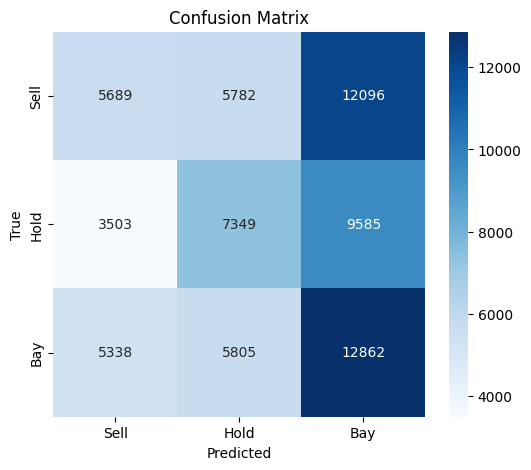

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Hold', 'Bay'], yticklabels=['Sell', 'Hold', 'Bay'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
best_params_lstm['features'] = features
best_params_lstm['input_dim'] = len(features)
best_params_lstm['output_dim'] = 3

In [21]:
torch.save({
    'model_state_dict': best_model_lstm.state_dict(),
**best_params_lstm
}, "lstm_model_mini_with_config.pth")

In [22]:
def get_predictions_lstm(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for x_batch, _ in data_loader:
            x_batch = x_batch.to(device)
            output = model(x_batch)
            
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_preds), np.array(all_probs)

In [23]:
#Находим стандартные предсказания и их вероятности
lstm_test_preds, lstm_test_probs = get_predictions_lstm(best_model_lstm, lstm_data['test_loader'], device)

In [24]:
#Установим планку вероятности для совершения сделки на покупку/продажу (выше чем стандартную)
threshold = 0.5
predicted_classes = []

for probs in lstm_test_probs:
    high_prob_classes = np.where(probs >= threshold)[0]

    if len(high_prob_classes) == 1:
        predicted_classes.append(high_prob_classes[0])
    elif len(high_prob_classes) > 1:
        predicted_classes.append(np.argmax(probs))
    else:
        predicted_classes.append(1)

predicted_classes = np.array(predicted_classes)

In [25]:
test_pred_lstm = lstm_data['test_raw']
test_pred_lstm['lstm_pred_norm'] = lstm_test_preds
test_pred_lstm['lstm_pred_high'] = predicted_classes

#### Проведем бектестинг

In [29]:
test_pred_lstm.loc[:,["signal"]] = test_pred_lstm['lstm_pred_norm']
test_pred_lstm.loc[:,["signal_"]] = test_pred_lstm['lstm_pred_high']

In [30]:
test_pred_lstm[test_pred_lstm['tic']=='SBER']['signal'].value_counts()

signal
1    169
2    114
0     44
Name: count, dtype: int64

In [31]:
test_pred_lstm[test_pred_lstm['tic']=='SBER']['signal_'].value_counts()

signal_
1    327
Name: count, dtype: int64

In [32]:
# Добавим столбец где будет указан id трейда
def prepare_data(test_df):
    for ticker in df.tic.unique():
        test_df.loc[test_df['tic'] == ticker,['shift']] = test_df.loc[test_df['tic'] == ticker,'signal'].shift()
        test_df.loc[test_df['tic'] == ticker,['shift']].fillna(0, inplace=True)
        test_df.loc[test_df['tic'] == ticker,['action_x']] =test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'shift'])
        test_df.loc[test_df['tic'] == ticker,['action_id']] = test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'signal'].shift()).cumsum()
    return test_df
test_pred_lstm = prepare_data(test_pred_lstm)

In [33]:
#Создаем стратегию для покупки / продажи согласно модели
def sma(source, period):
    return pd.Series(source).rolling(period).mean().to_numpy()


class ML_strategy(Strategy):
    def init(self):

        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0
        #SMA
        self.sma50 = self.I(sma, self.data.Close, 50)
        self.sma200 = self.I(sma, self.data.Close, 200)

        # RSI
        close = self.data.Close
        delta = np.diff(close)
        delta = np.insert(delta, 0, 0)  # чтобы длина совпадала
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)

        avg_gain = talib.SMA(gain, timeperiod=14)
        avg_loss = talib.SMA(loss, timeperiod=14)

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        self.rsi = rsi
        
    def next(self):
        
        current_signal = self.signal[-1]
        if current_signal != self.previous_signal:

            if current_signal == 2:
                # Только если RSI < 70 и цена выше SMA200 (тренд вверх)
                if True:
#                if self.rsi[-1] < 70 and self.data.Close[-1] > self.sma200[-1]:                    
                    if self.position.is_short:
                        self.position.close()
                    if not self.position.is_long:
                        self.buy()                  

            elif current_signal == 0:
                # Только если RSI > 20 и цена ниже SMA200 (тренд вниз)
                if True:
#                if self.rsi[-1] > 20 and self.data.Close[-1] < self.sma200[-1]:                    
                    if self.position.is_long:
                        self.position.close()
                    if not self.position.is_short:
                        self.sell()
            elif current_signal == 1:
                if self.position:
                    True#self.position.close()


        self.previous_signal = current_signal
        
# Делаем для каждой модели и акции свой объект класса Backtest
def bt_str(test_df):    
    db_all = pd.DataFrame()
    for ticker in test_df.tic.unique():  
        # Подготовка данных для бэктестинга
        bt_df = test_df[test_df['tic'] == ticker].copy()
        bt_df.columns = bt_df.columns.str.capitalize()
        bt_df.rename(columns={'Date': 'Datetime'}, inplace=True)
        bt_df["Datetime"] = pd.to_datetime(bt_df["Datetime"])
        bt_df.set_index('Datetime', inplace=True)
        
        # Создаем объект класса Backtest
        bt = Backtest(bt_df, ML_strategy, cash=1_000_000, commission=.002, exclusive_orders=True) # сделки идут последовательно
        
        stats = bt.run()
        
        db_all[ticker] =  stats[:28]
    return db_all
    
#Запускаем  
bt_df = test_pred_lstm[test_pred_lstm['tic'].isin(['GAZP','SBER','LKOH','ROSN','NVTK','GMKN','YNDX','MTSS','TATN','PLZL'])]
result_lstm = bt_str(bt_df)

In [34]:
result_lstm

,GAZP,GMKN,LKOH,MTSS,NVTK,PLZL,ROSN,SBER,TATN
Start,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00,2024-03-18 00:00:00
End,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-31 00:00:00,2025-05-29 00:00:00
Duration,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,439 days 00:00:00,437 days 00:00:00
Exposure Time [%],25.688073,0.0,11.314985,37.003058,31.384615,34.876543,37.920489,38.53211,27.076923
Equity Final [$],1064085.01102,1026786.25348,896748.67,1263973.5535,818329.4348,1238458.2282,599770.4318,1102233.60088,1270856.6796
Equity Peak [$],1345554.2352,1090505.29348,1062626.818,1287022.1477,1156937.2068,1422479.1322,1121951.3554,1136290.35562,1340303.8796
Commissions [$],18631.67258,NaN,16331.986,70769.2005,48576.5372,61886.3318,63269.9374,50385.4264,76793.8364
Return [%],6.408501,2.678625,-10.325133,26.397355,-18.167057,23.845823,-40.022957,10.22336,27.085668
Buy & Hold Return [%],8.586689,-5.905097,-0.709791,11.935318,20.362683,23.055616,-25.205169,16.79655,9.995202
Return (Ann.) [%],4.903287,2.083739,-8.055432,19.785317,-14.397619,18.097597,-32.561809,7.789847,20.424509


In [35]:
def analyze_backtest_results(df):
    """
    Возвращает сводную статистику по всем акциям в отформатированном виде.
    """
    metrics = {
        'Total Trades': df.loc['# Trades'].sum(),
        'Win Rate [%]': df.loc['Win Rate [%]'].mean(),  # среднее по всем тикерам
        'Avg. Trade Duration': str(pd.to_timedelta(df.loc['Avg. Trade Duration']).mean()).split('.')[0],
        'Sharpe Ratio': df.loc['Sharpe Ratio'].mean() if 'Sharpe Ratio' in df.index else float('nan'),
        'Sortino Ratio': df.loc['Sortino Ratio'].mean() if 'Sortino Ratio' in df.index else float('nan'),
    }

    # Вычисляем общий Return на основе начального и финального капитала
    initial_capital = 1_000_000 * len(df.columns)
    final_equity = df.loc['Equity Final [$]'].sum()
    total_return = (final_equity - initial_capital) / initial_capital * 100
    metrics['Total Return (%)'] = total_return

    # Форматируем значения: проценты и округление
    formatted_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, (int, float)) and not isinstance(value, str):
            if key.endswith('(%)') or '%' in key:
                formatted_metrics[key] = f"{value:.2f}%"
            elif pd.isna(value):
                formatted_metrics[key] = "NaN"
            else:
                formatted_metrics[key] = f"{value:.2f}"
        else:
            formatted_metrics[key] = value  

    return pd.Series(formatted_metrics)

In [36]:
from rich.console import Console
from rich.table import Table
from rich.panel import Panel

console = Console()

def print_results(summary, model_name="LSTM"):
    table = Table(title=f"📊 Результаты {model_name} модели", show_header=True, header_style="bold magenta")
    table.add_column("Метрика", style="cyan")
    table.add_column("Значение", style="green")

    for key, value in summary.items():
        table.add_row(str(key), str(value))

    console.print(Panel(table, border_style="bright_blue"))

summary_lstm = analyze_backtest_results(result_lstm)
print_results(summary_lstm, "LSTM")

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│         📊 Результаты LSTM модели                                                                               │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓                                                                      │
│ ┃ Метрика             ┃ Значение         ┃                                                                      │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩                                                                      │
│ │ Total Trades        │ 96.00            │                                                                      │
│ │ Win Rate [%]        │ 51.20%           │                                                                      │
│ │ Avg. Trade Duration │ 12 days 18:00:00 │                                                                      │
│ │ Sharpe Ratio        │ 0.03             │                                                                      │
│ │ Sortino Ratio       │ 0.40             │                                                                      │
│ │ Total Return (%)    │ 3.12%            │                                                                      │
│ └─────────────────────┴──────────────────┘                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

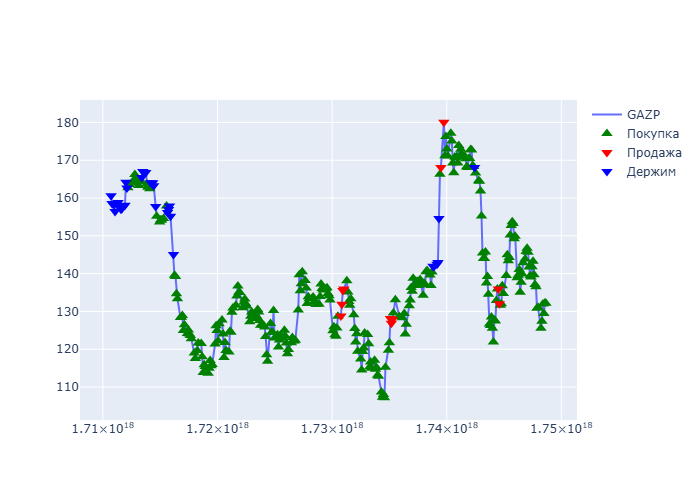

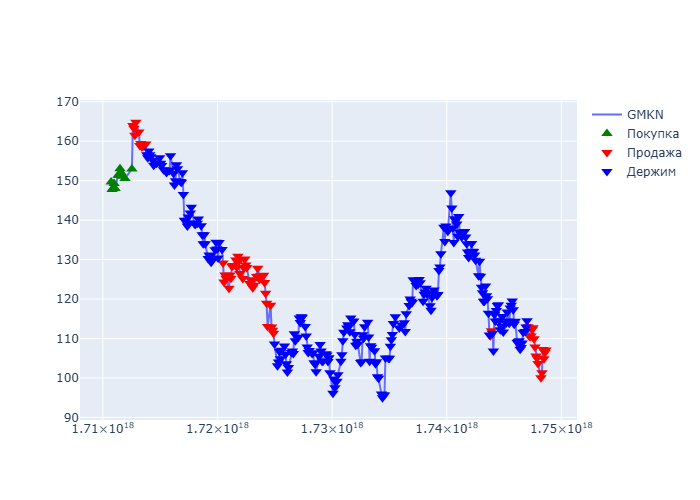

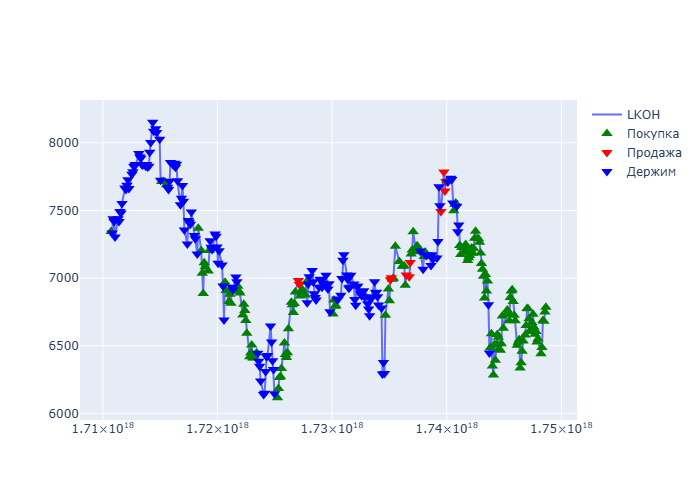

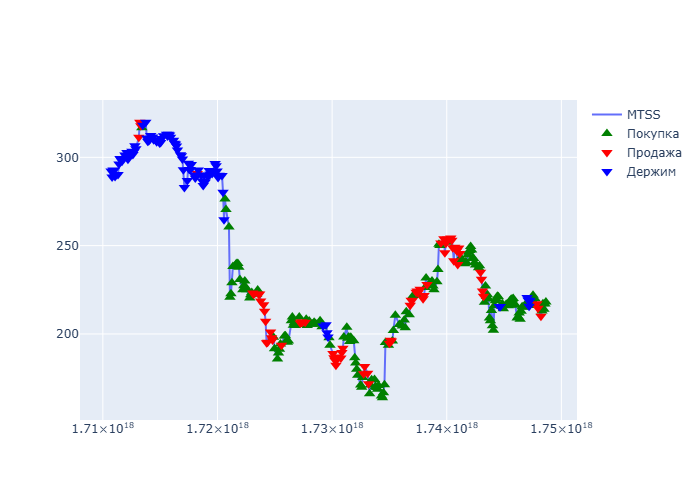

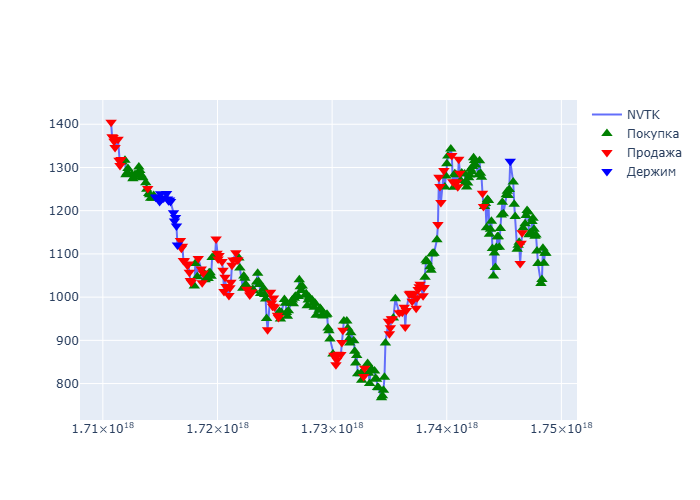

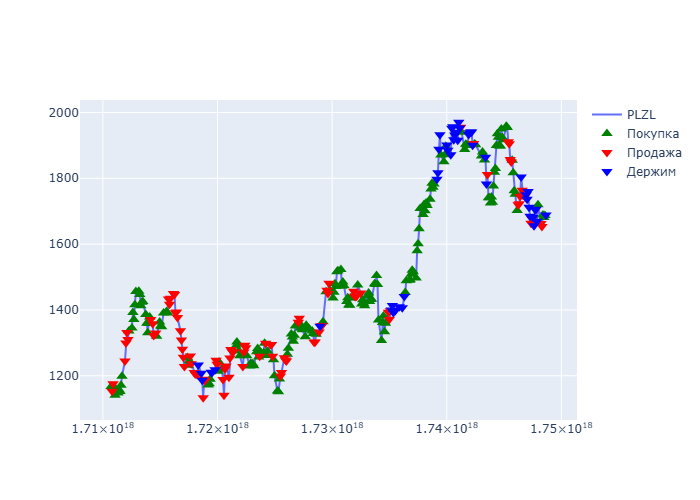

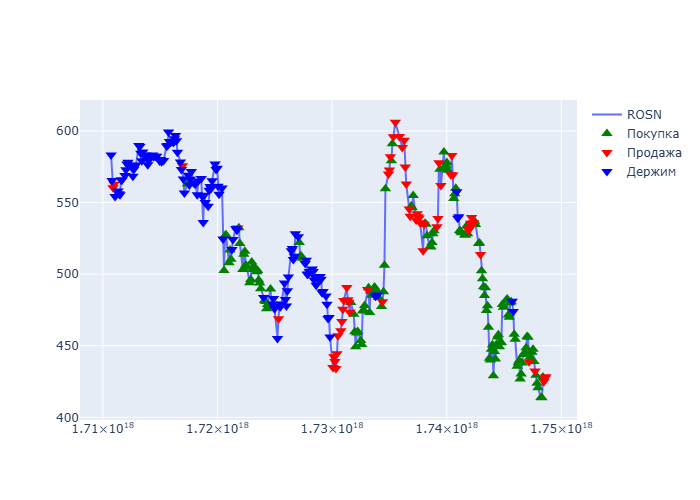

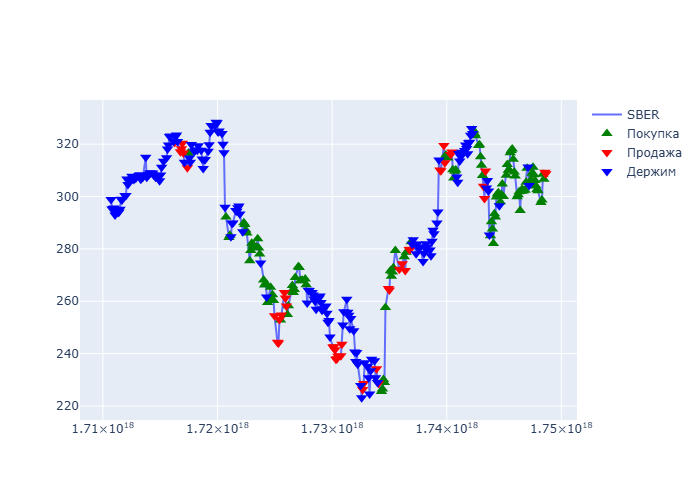

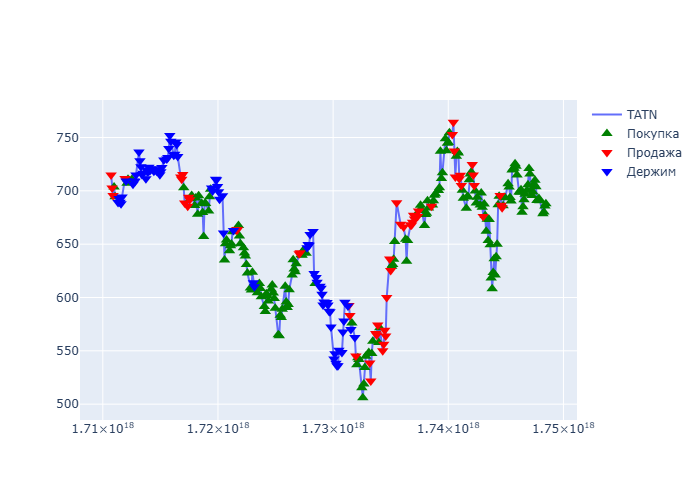

In [43]:
#Функция по отрисовке акций и сигналов на покупку/продажу
def draw_signals(test_df):
    
    # Добавляем сигналы покупки и продажи
    buy_signals = test_df[test_df['signal'] == 2]
    sell_signals = test_df[test_df['signal'] == 0]
    hold_signals = test_df[test_df['signal'] == 1]
    
    for ticker in test_df.tic.unique():
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(x = test_df[test_df['tic'] == ticker]['Date'], y = test_df[test_df['tic'] == ticker]['Close'], name=ticker, visible=True))
        
        fig.add_trace(go.Scatter(x=buy_signals[buy_signals['tic']==ticker]['Date'], y = buy_signals[buy_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Покупка', marker=dict(symbol='triangle-up', size=10, color='green')))
        fig.add_trace(go.Scatter(x=sell_signals[sell_signals['tic']==ticker]['Date'], y=sell_signals[sell_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Продажа', marker=dict(symbol='triangle-down', size=10, color='red')))
        fig.add_trace(go.Scatter(x=hold_signals[hold_signals['tic']==ticker]['Date'], y=hold_signals[hold_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Держим', marker=dict(symbol='triangle-down', size=10, color='blue')))


        
        fig.show("png") 
draw_signals(bt_df)

In [41]:
import numpy as np
from sklearn.metrics import f1_score
from tqdm import tqdm

def permutation_feature_importance(model, dataloader, device, metric_func, n_repeats=5):
    base_preds = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            base_preds.append(preds)

    y_true = torch.cat([y for _, y in dataloader]).cpu().numpy()
    base_preds = np.concatenate(base_preds)
    base_score = metric_func(y_true, base_preds, average='weighted')

    n_features = dataloader.dataset.tensors[0].shape[2]
    feature_importance = np.zeros((n_features, n_repeats))

    print(f"Base score (weighted F1): {base_score:.4f}")

    for feature_idx in tqdm(range(n_features), desc="Permuting features"):
        for repeat in range(n_repeats):
            all_preds = []
            with torch.no_grad():
                for X_batch, _ in dataloader:
                    X_batch = X_batch.to(device)
                    X_permuted = X_batch.clone()

                    for i in range(X_permuted.shape[0]):
                        X_permuted[i, :, feature_idx] = X_permuted[i, torch.randperm(X_permuted.shape[1]), feature_idx]

                    outputs = model(X_permuted)
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    all_preds.append(preds)

            score = metric_func(y_true, np.concatenate(all_preds), average='weighted')
            feature_importance[feature_idx, repeat] = base_score - score

    mean_importance = np.mean(feature_importance, axis=1)
    std_importance = np.std(feature_importance, axis=1)

    return mean_importance, std_importance

In [39]:
mean_imp, std_imp = permutation_feature_importance(
    best_model_lstm,
    lstm_data['test_loader'],
    device,
    f1_score,
    n_repeats=5
)

Base score (weighted F1): 0.3708


Permuting features: 100%|██████████| 43/43 [47:50<00:00, 66.76s/it]


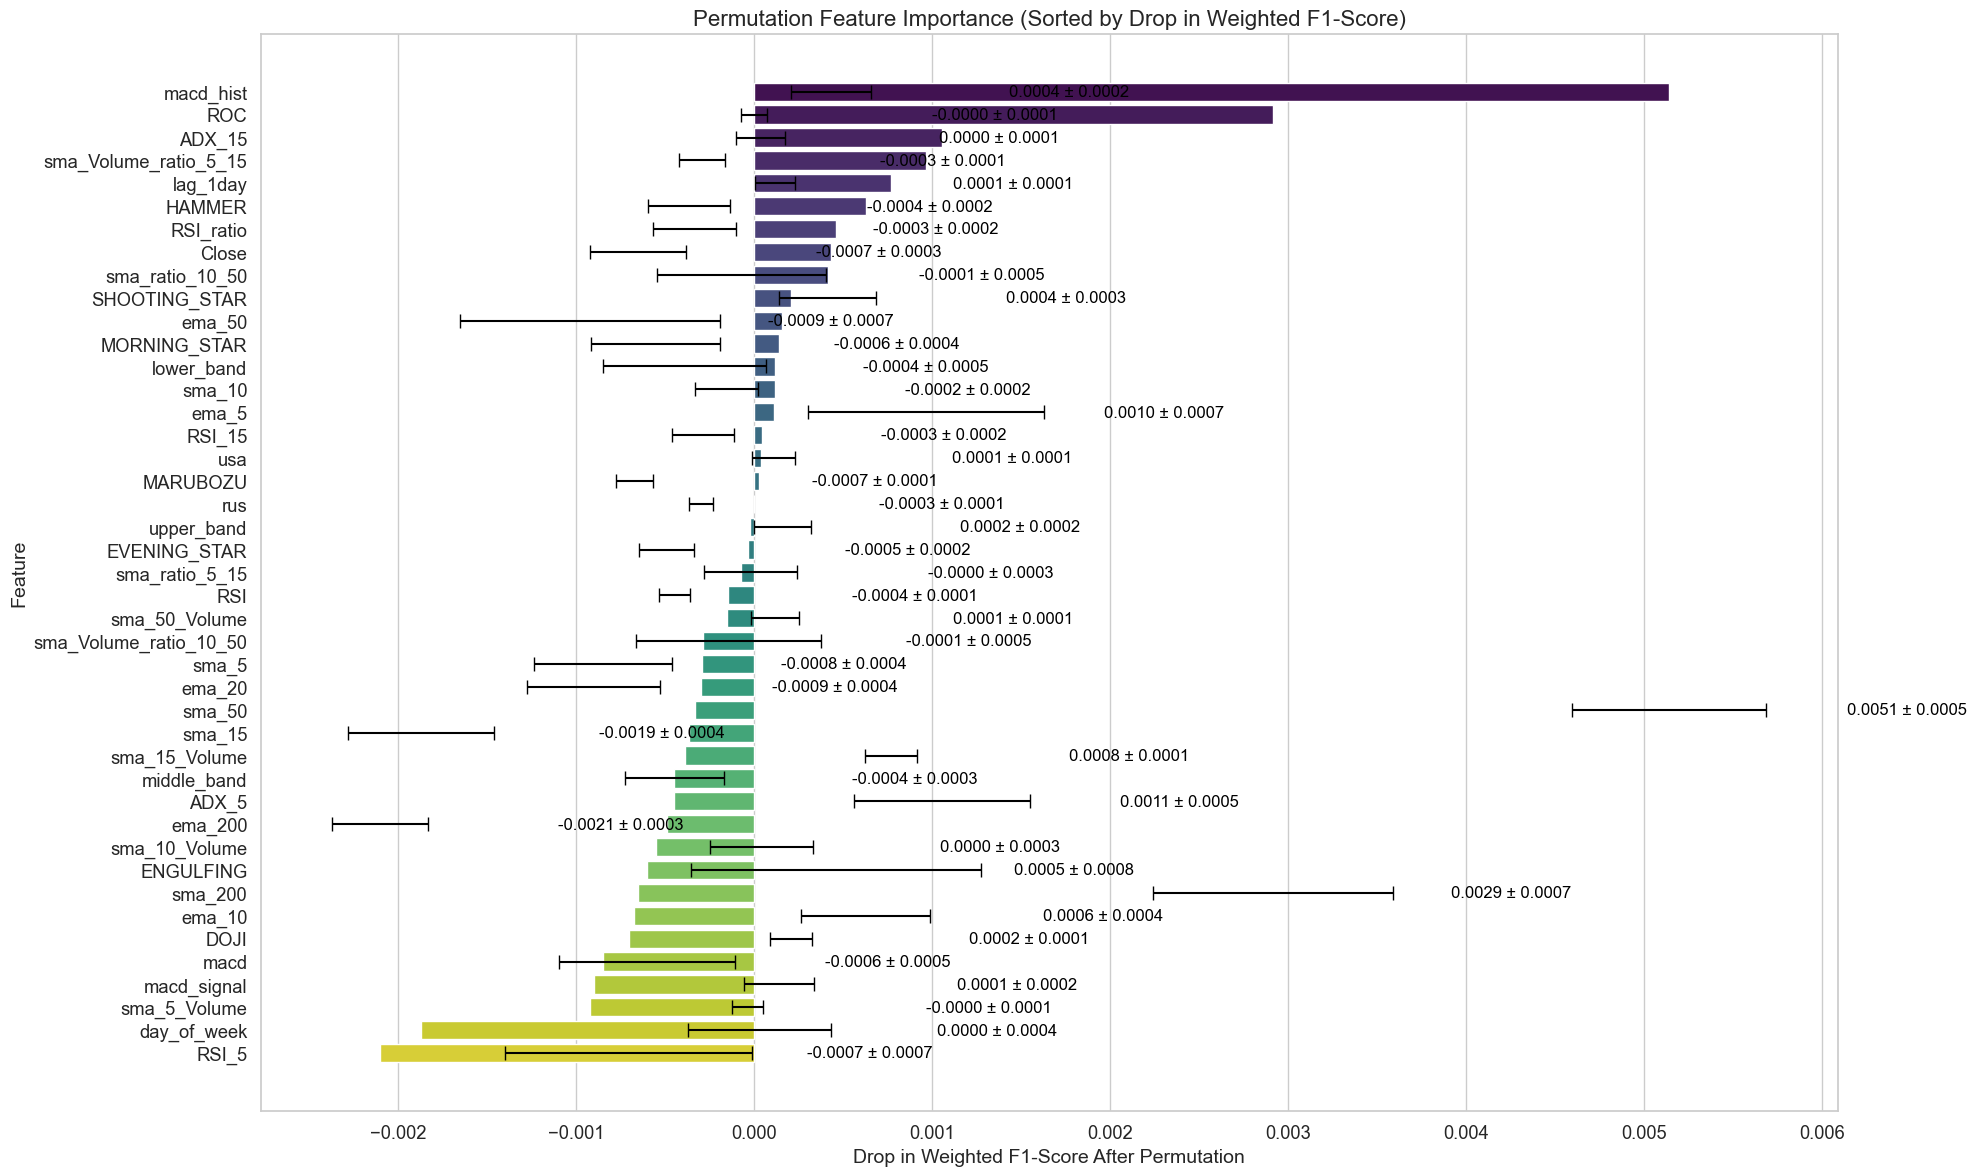

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

data = pd.DataFrame({
    'Feature': features,
    'Importance': mean_imp,
    'Std': std_imp
})

data = data.sort_values(by='Importance', ascending=False)

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(20, 12))
ax = sns.barplot(x='Importance', y='Feature', data=data, palette="viridis")

for idx, row in data.iterrows():
    ax.errorbar(
        x=row['Importance'],
        y=idx,
        xerr=row['Std'],
        fmt='none',
        c='black',
        capsize=5
    )

for index, row in data.iterrows():
    ax.text(row['Importance'] + 0.001, index,
            f'{row["Importance"]:.4f} ± {row["Std"]:.4f}',
            va='center', fontsize=12, color='black')

plt.title("Permutation Feature Importance (Sorted by Drop in Weighted F1-Score)", fontsize=16)
plt.xlabel("Drop in Weighted F1-Score After Permutation", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

In [92]:
torch.cuda.empty_cache()

In [86]:
print(torch.cuda.memory_allocated())   # Используемая память
print(torch.cuda.memory_reserved())    # Зарезервированная память

1193527296
1398800384


In [93]:
import gc
gc.collect()

3629